In [27]:
import numpy as np
import pandas as pd

# For statistical tests
from scipy import stats

# For visualization
%matplotlib notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# For pandas profiling
# from pandas_profiling import ProfileReport

# Show all columns
pd.set_option('display.max_columns', None)

# For text EDA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# For entropy computation
from pyitlib import discrete_random_variable as drv

# For mapping to Google Drive
# from google.colab import drive


from imblearn.combine import SMOTEENN

import warnings
warnings.filterwarnings("ignore")

In [28]:
# Initiate dataframe
df_train = pd.read_csv('train.csv', index_col=None)
df_test = pd.read_csv('test.csv', index_col=None)
df_valid = pd.read_csv('valid.csv', index_col=None)

In [8]:
# Dropping Age and adding normalised age
from sklearn import preprocessing

def norm_age(df):
    scaler = preprocessing.MinMaxScaler()
    normalised_age = scaler.fit_transform(df[['Age']])
    new_df = df.copy(deep=True)
    new_df["Normalised_Age"] = normalised_age
    return new_df.drop('Age', axis=1, inplace=False)

df_train_normalised_age = norm_age(df_train)
df_test_normalised_age = norm_age(df_test)
df_valid_normalised_age = norm_age(df_valid)

In [9]:
import optuna
from sklearn import linear_model
from sklearn import ensemble
from sklearn import datasets
from sklearn import model_selection

In [30]:
X_train = df_train.drop('FraudFound_P', axis=1).values
y_train = df_train['FraudFound_P'].values

X_test = df_test.drop('FraudFound_P', axis=1).values
y_test = df_test['FraudFound_P'].values

X_valid = df_valid.drop('FraudFound_P', axis=1).values
y_valid = df_valid['FraudFound_P'].values

smote_enn = SMOTEENN(random_state=0, sampling_strategy=0.6)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

In [31]:
#Step 1. Define an objective function to be maximized.
def objective(trial):
    
    # Step 2. Setup values for the hyperparameters:
    rf_n_estimators = trial.suggest_int("n_estimators", 10, 1000)
    rf_max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    rf_min_samples_split = trial.suggest_int('min_samples_split', 2, 150)
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 60)
    rf_bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    rf_max_features = trial.suggest_categorical("max_features", ['auto', 'sqrt'])
    
    classifier_obj = ensemble.RandomForestClassifier(
        max_depth=rf_max_depth,
        n_estimators=rf_n_estimators,
        min_samples_split=rf_min_samples_split,
        min_samples_leaf=rf_min_samples_leaf,
        bootstrap = rf_bootstrap,
        max_features=rf_max_features,
        random_state = 0
    )
    
    cl_model = classifier_obj.fit(X_train_resampled,y_train_resampled)

    # Step 3: Scoring method:
    predictions = cl_model.predict(X_valid)
    return metrics.fbeta_score(y_valid, predictions, beta=0.75)

#     score = model_selection.cross_val_score(classifier_obj, X_train_resampled, y_train_resampled, n_jobs=-1, cv=3)
#     accuracy = score.mean()
#     return accuracy

# Step 4: Running it
study2 = optuna.create_study(direction="maximize")
study2.optimize(objective, n_trials=100)

[I 2022-11-13 11:56:44,972] A new study created in memory with name: no-name-b5f8308d-4ece-4f65-a6a0-e5dadbe93b11
[I 2022-11-13 11:56:58,190] Trial 0 finished with value: 0.20014894805436603 and parameters: {'n_estimators': 948, 'max_depth': 6, 'min_samples_split': 81, 'min_samples_leaf': 29, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 0 with value: 0.20014894805436603.
[I 2022-11-13 11:57:05,062] Trial 1 finished with value: 0.23736723527518505 and parameters: {'n_estimators': 394, 'max_depth': 12, 'min_samples_split': 59, 'min_samples_leaf': 19, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 1 with value: 0.23736723527518505.
[I 2022-11-13 11:57:10,326] Trial 2 finished with value: 0.19443984775773623 and parameters: {'n_estimators': 666, 'max_depth': 4, 'min_samples_split': 121, 'min_samples_leaf': 55, 'bootstrap': True, 'max_features': 'auto'}. Best is trial 1 with value: 0.23736723527518505.
[I 2022-11-13 11:57:11,302] Trial 3 finished with value: 0.1758

[I 2022-11-13 11:58:49,170] Trial 28 finished with value: 0.22176731490958718 and parameters: {'n_estimators': 296, 'max_depth': 16, 'min_samples_split': 29, 'min_samples_leaf': 38, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 12 with value: 0.24711696869851726.
[I 2022-11-13 11:59:01,154] Trial 29 finished with value: 0.1980148385803088 and parameters: {'n_estimators': 847, 'max_depth': 7, 'min_samples_split': 53, 'min_samples_leaf': 53, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 12 with value: 0.24711696869851726.
[I 2022-11-13 11:59:02,534] Trial 30 finished with value: 0.23457235654998193 and parameters: {'n_estimators': 72, 'max_depth': 24, 'min_samples_split': 92, 'min_samples_leaf': 32, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 12 with value: 0.24711696869851726.
[I 2022-11-13 11:59:08,127] Trial 31 finished with value: 0.23711666139740753 and parameters: {'n_estimators': 311, 'max_depth': 21, 'min_samples_split': 14, 'min_samples_l

[I 2022-11-13 12:00:39,515] Trial 57 finished with value: 0.2078042022627569 and parameters: {'n_estimators': 110, 'max_depth': 8, 'min_samples_split': 140, 'min_samples_leaf': 24, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 51 with value: 0.2497502497502498.
[I 2022-11-13 12:00:43,839] Trial 58 finished with value: 0.24761230986911922 and parameters: {'n_estimators': 200, 'max_depth': 16, 'min_samples_split': 125, 'min_samples_leaf': 18, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 51 with value: 0.2497502497502498.
[I 2022-11-13 12:00:47,627] Trial 59 finished with value: 0.2326628640048034 and parameters: {'n_estimators': 197, 'max_depth': 11, 'min_samples_split': 104, 'min_samples_leaf': 17, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 51 with value: 0.2497502497502498.
[I 2022-11-13 12:00:48,115] Trial 60 finished with value: 0.22423496306718252 and parameters: {'n_estimators': 21, 'max_depth': 16, 'min_samples_split': 118, 'min_samples_l

[I 2022-11-13 12:02:02,494] Trial 86 finished with value: 0.23348322379799374 and parameters: {'n_estimators': 41, 'max_depth': 16, 'min_samples_split': 133, 'min_samples_leaf': 14, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 51 with value: 0.2497502497502498.
[I 2022-11-13 12:02:03,892] Trial 87 finished with value: 0.23651844843897826 and parameters: {'n_estimators': 75, 'max_depth': 13, 'min_samples_split': 126, 'min_samples_leaf': 22, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 51 with value: 0.2497502497502498.
[I 2022-11-13 12:02:08,138] Trial 88 finished with value: 0.23715074163504657 and parameters: {'n_estimators': 216, 'max_depth': 15, 'min_samples_split': 18, 'min_samples_leaf': 31, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 51 with value: 0.2497502497502498.
[I 2022-11-13 12:02:11,513] Trial 89 finished with value: 0.24289312702410937 and parameters: {'n_estimators': 166, 'max_depth': 18, 'min_samples_split': 119, 'min_samples_

In [26]:
study2.best_value

0.2481565513329552

In [32]:
trial = study2.best_trial

print(f"Trial of Choice: ")
print(f"\tnumber: {trial.number}")
print(f"\tparams: {trial.params}")
print(f"\tvalues: {trial.values}")

Trial of Choice: 
	number: 51
	params: {'n_estimators': 43, 'max_depth': 16, 'min_samples_split': 125, 'min_samples_leaf': 27, 'bootstrap': False, 'max_features': 'auto'}
	values: [0.2497502497502498]


In [33]:
rf_test = RandomForestClassifier()
rf_test.set_params(**trial.params)
rf_test.fit(X_train_resampled,y_train_resampled)

# make predictions for test data
y_pred = rf_test.predict(X_test)
predictions = [round(value) for value in y_pred]

# Model Accuracy, how often is the classifier correct?
print("Precision:", round(metrics.precision_score(y_test,predictions)*100,2), "%")
print("Accuracy:", round(metrics.accuracy_score(y_test, predictions) * 100,2), "%")
print("Recall:", round(metrics.recall_score(y_test,predictions) * 100,2), "%")
print("F1 score:", round(metrics.f1_score(y_test,predictions) * 100,2), "%")
print("ROC AUC:", metrics.roc_auc_score(y_test,predictions))
print("PR AUC:", metrics.average_precision_score(y_test,predictions))


print(metrics.classification_report(y_test, predictions))

Precision: 15.77 %
Accuracy: 85.08 %
Recall: 35.07 %
F1 score: 21.76 %
ROC AUC: 0.6164805956141396
PR AUC: 0.09372963839852252
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      2131
           1       0.16      0.35      0.22       134

    accuracy                           0.85      2265
   macro avg       0.56      0.62      0.57      2265
weighted avg       0.91      0.85      0.88      2265



In [52]:
#Step 1. Define an objective function to be maximized.
def objective(trial):
    
    # Step 2. Setup values for the hyperparameters:
    rf_n_estimators = trial.suggest_int("n_estimators", 10, 1000)
    rf_max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    rf_min_samples_split = trial.suggest_int('min_samples_split', 2, 150)
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 60)
    rf_bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    rf_max_features = trial.suggest_categorical("max_features", ['auto', 'sqrt'])
    
    classifier_obj = ensemble.RandomForestClassifier(
        max_depth=rf_max_depth,
        n_estimators=rf_n_estimators,
        min_samples_split=rf_min_samples_split,
        min_samples_leaf=rf_min_samples_leaf,
        bootstrap = rf_bootstrap,
        max_features=rf_max_features,
        random_state = 0
    )
    
    cl_model = classifier_obj.fit(X_train_resampled,y_train_resampled)

    # Step 3: Scoring method:
    predictions = cl_model.predict(X_valid)
    return metrics.recall_score(y_valid, predictions)

#     score = model_selection.cross_val_score(classifier_obj, X_train_resampled, y_train_resampled, n_jobs=-1, cv=3)
#     accuracy = score.mean()
#     return accuracy

# Step 4: Running it
study3 = optuna.create_study(direction="maximize")
study3.optimize(objective, n_trials=100)

[I 2022-11-12 23:05:06,009] A new study created in memory with name: no-name-225c0b58-f209-4e36-9b01-483537c2ebc8
[I 2022-11-12 23:05:18,922] Trial 0 finished with value: 0.5447761194029851 and parameters: {'n_estimators': 530, 'max_depth': 9, 'min_samples_split': 30, 'min_samples_leaf': 50, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5447761194029851.
[I 2022-11-12 23:05:33,114] Trial 1 finished with value: 0.6044776119402985 and parameters: {'n_estimators': 664, 'max_depth': 7, 'min_samples_split': 59, 'min_samples_leaf': 24, 'bootstrap': True, 'max_features': 'auto'}. Best is trial 1 with value: 0.6044776119402985.
[I 2022-11-12 23:06:06,126] Trial 2 finished with value: 0.40298507462686567 and parameters: {'n_estimators': 933, 'max_depth': 26, 'min_samples_split': 133, 'min_samples_leaf': 57, 'bootstrap': False, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6044776119402985.
[I 2022-11-12 23:06:25,140] Trial 3 finished with value: 0.5522388059

[I 2022-11-12 23:09:10,671] Trial 29 finished with value: 0.6343283582089553 and parameters: {'n_estimators': 543, 'max_depth': 5, 'min_samples_split': 139, 'min_samples_leaf': 27, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.746268656716418.
[I 2022-11-12 23:09:13,620] Trial 30 finished with value: 0.7089552238805971 and parameters: {'n_estimators': 113, 'max_depth': 4, 'min_samples_split': 122, 'min_samples_leaf': 48, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 7 with value: 0.746268656716418.
[I 2022-11-12 23:09:16,689] Trial 31 finished with value: 0.6492537313432836 and parameters: {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 124, 'min_samples_leaf': 50, 'bootstrap': False, 'max_features': 'auto'}. Best is trial 7 with value: 0.746268656716418.
[I 2022-11-12 23:09:22,040] Trial 32 finished with value: 0.7089552238805971 and parameters: {'n_estimators': 219, 'max_depth': 4, 'min_samples_split': 127, 'min_samples_leaf': 28, '

[I 2022-11-12 23:12:32,246] Trial 58 finished with value: 0.664179104477612 and parameters: {'n_estimators': 286, 'max_depth': 5, 'min_samples_split': 137, 'min_samples_leaf': 34, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.746268656716418.
[I 2022-11-12 23:12:35,896] Trial 59 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 247, 'max_depth': 3, 'min_samples_split': 58, 'min_samples_leaf': 25, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.746268656716418.
[I 2022-11-12 23:12:40,778] Trial 60 finished with value: 0.5522388059701493 and parameters: {'n_estimators': 200, 'max_depth': 8, 'min_samples_split': 70, 'min_samples_leaf': 25, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.746268656716418.
[I 2022-11-12 23:12:44,203] Trial 61 finished with value: 0.7164179104477612 and parameters: {'n_estimators': 247, 'max_depth': 3, 'min_samples_split': 55, 'min_samples_leaf': 32, 'bootst

[I 2022-11-12 23:14:22,341] Trial 87 finished with value: 0.6791044776119403 and parameters: {'n_estimators': 131, 'max_depth': 4, 'min_samples_split': 76, 'min_samples_leaf': 21, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.746268656716418.
[I 2022-11-12 23:14:23,396] Trial 88 finished with value: 0.6268656716417911 and parameters: {'n_estimators': 90, 'max_depth': 2, 'min_samples_split': 115, 'min_samples_leaf': 28, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.746268656716418.
[I 2022-11-12 23:14:30,766] Trial 89 finished with value: 0.4253731343283582 and parameters: {'n_estimators': 277, 'max_depth': 12, 'min_samples_split': 90, 'min_samples_leaf': 30, 'bootstrap': True, 'max_features': 'sqrt'}. Best is trial 7 with value: 0.746268656716418.
[I 2022-11-12 23:14:33,472] Trial 90 finished with value: 0.7238805970149254 and parameters: {'n_estimators': 182, 'max_depth': 3, 'min_samples_split': 83, 'min_samples_leaf': 26, 'boots

In [53]:
trial = study3.best_trial

print(f"Trial of Choice: ")
print(f"\tnumber: {trial.number}")
print(f"\tparams: {trial.params}")
print(f"\tvalues: {trial.values}")

Trial of Choice: 
	number: 7
	params: {'n_estimators': 165, 'max_depth': 3, 'min_samples_split': 109, 'min_samples_leaf': 22, 'bootstrap': True, 'max_features': 'auto'}
	values: [0.746268656716418]


In [11]:
rf_test2 = RandomForestClassifier()
# rf_test2.set_params(**trial.params)
rf_test2.set_params(**{'n_estimators': 165, 'max_depth': 3, 'min_samples_split': 109, 'min_samples_leaf': 22, 'bootstrap': True, 'max_features': 'auto'})
rf_test2.fit(X_train_resampled,y_train_resampled)

# make predictions for test data
y_pred = rf_test2.predict(X_test)
predictions = [round(value) for value in y_pred]

# Model Accuracy, how often is the classifier correct?
print("Precision:", round(metrics.precision_score(y_test,predictions)*100,2), "%")
print("Accuracy:", round(metrics.accuracy_score(y_test, predictions) * 100,2), "%")
print("Recall:", round(metrics.recall_score(y_test,predictions) * 100,2), "%")
print("F1 score:", round(metrics.f1_score(y_test,predictions) * 100,2), "%")
print("ROC AUC:", metrics.roc_auc_score(y_test,predictions))
print("PR AUC:", metrics.average_precision_score(y_test,predictions))


print(metrics.classification_report(y_test, predictions))

Precision: 13.79 %
Accuracy: 72.05 %
Recall: 70.9 %
F1 score: 23.09 %
ROC AUC: 0.7151064247042591
PR AUC: 0.11496998900957492
              precision    recall  f1-score   support

           0       0.98      0.72      0.83      2131
           1       0.14      0.71      0.23       134

    accuracy                           0.72      2265
   macro avg       0.56      0.72      0.53      2265
weighted avg       0.93      0.72      0.79      2265



In [29]:
import shap
# Fits the explainer
explainer = shap.Explainer(rf_test2.predict, X_train_resampled, seed=0)
shap_values = explainer(X_train_resampled[1:1000,:])

Permutation explainer: 1000it [06:00,  2.69it/s]                        


In [24]:
feature_list = list(df_train_normalised_age.drop('FraudFound_P', axis=1).columns)

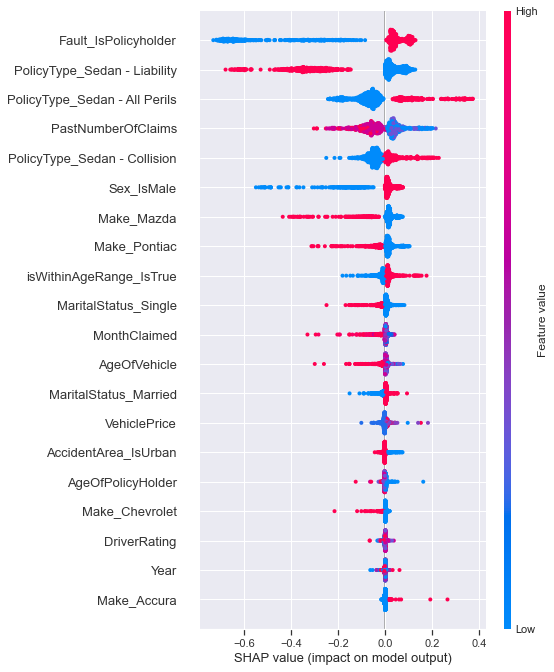

In [26]:
shap.summary_plot(shap_values, X_train_resampled[1:1000,:],feature_list)